# Satelite Alternative Data Project

In [25]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import os
import yfinance as yf
from colorthief import ColorThief

## Read in the images in the format of RGB values

In [26]:
image_df = pd.DataFrame(columns = ['date', 'R', 'G', 'B'])
for filename in os.listdir('satellite_imagery'):
    if filename.endswith('.png'):
        date = datetime.strptime(filename[8:16],"%Y%m%d")
        color_thief = ColorThief('satellite_imagery/' + filename)
        #extract rgb elements from png file
        dom_color = color_thief.get_color(quality = 1)
        image_df = image_df.append({'date': date, 
                        'R': dom_color[0], 
                        'G': dom_color[1], 
                        'B': dom_color[2]}, 
                        ignore_index=True)

In [27]:
image_df = image_df.sort_values(by = 'date')
image_df.head(6)

,date,R,G,B
14,2017-02-13,24,25,34
29,2017-03-17,9,15,27
18,2017-04-02,40,74,135
70,2017-04-18,40,71,126
25,2017-05-04,40,71,117
77,2017-06-21,16,21,30


In [28]:
#compare it with spy, s&p index
spy = yf.download("SPY", start="2017-01-02", end="2020-09-01")

[*********************100%***********************]  1 of 1 completed


In [29]:
spy=spy.reset_index()
spysubset=spy[["Date","Adj Close"]]
#closing price and date
spysubset['return']=spysubset['Adj Close'].pct_change()
spysubset=spysubset.drop(['Adj Close'], axis=1)
spysubset=spysubset.drop([0])
#only looking at pct_change as return
spysubset.head(6)

<ipython-input-29-ee8f80021713>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spysubset['return']=spysubset['Adj Close'].pct_change()


,Date,return
1,2017-01-04,0.005949
2,2017-01-05,-0.000795
3,2017-01-06,0.003578
4,2017-01-09,-0.003301
5,2017-01-10,0.000000
6,2017-01-11,0.002826


In [142]:
combine=spysubset.merge(image_df, left_on="Date", right_on="date",how="inner")
combine=combine.drop(['date'],axis=1)
combine.head(6)

,Date,return,R,G,B
0,2017-02-13,0.005443,24,25,34
1,2017-03-17,-0.001756,9,15,27
2,2017-04-18,-0.002984,40,71,126
3,2017-05-04,0.001174,40,71,117
4,2017-06-21,-0.000247,16,21,30
5,2017-08-24,-0.002331,18,36,60


## Machine Learning to find pattern - Fitting Gradient Boosting

In [143]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

In [144]:
X=combine.iloc[:,2:]
y=combine.iloc[:,1]

In [145]:
X=X.astype('float64')

In [146]:
y = y.round(5)

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [156]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr_clf = LinearRegression().fit(X_train, y_train)
lr_clf_pred = lr_clf.predict(X_test)

mean_squared_error(y_test, lr_clf_pred)

#lr_clf.score(x, y)
#lr_clf.coef_


8.858029061792116e-05

In [157]:
scores = cross_val_score(lr_clf, X, y, cv=5)
print(scores)
scores.mean()

[-2.33261404 -0.62468795 -3.41047998 -0.01339193 -0.0523864 ]


-1.286712061522684

In [149]:
gb = GradientBoostingRegressor(n_estimators=30, learning_rate=0.01, max_depth=4)
scores = cross_val_score(gb, X, y, cv=5)
print(scores)
scores.mean()

[-4.1991462   0.03012975 -0.03916169  0.09344947  0.01786909]


-0.8193719155006454

In [150]:
#with grid search
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, cross_validate

kfold = 5

GBC = GradientBoostingRegressor()
gb_param = [{
              'n_estimators' : [30,40,50,70,100],
              'learning_rate': [0.01, 0.05, 0.1, 0.2],
              'max_depth': [4,5,6,7,8],
              }]

gs_GBC = GridSearchCV(GBC, param_grid = gb_param, cv=kfold, n_jobs= 2, verbose = 1)

gs_GBC.fit(combine.iloc[:,2:],combine.iloc[:,1])
gs_GBC.best_params_


Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 30}

In [151]:
gs_GBC_result = cross_val_score(gs_GBC, X_test, y_test, scoring = "accuracy", cv = kfold, n_jobs=2)
gs_GBC_result.mean()

nan

In [141]:
##randon
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
RF_clf = RandomForestRegressor(n_estimators=100, max_features = 3, oob_score = True, random_state=42 )
RF_clf.fit(X_train, y_train)
##regression use score function, not cross_val_score function
pred=RF_clf.predict(X_test)
print(pred)
RF_clf.score(X_test, y_test)
#scores = cross_val_score(RF_clf, X, y, cv=5, scoring="accuracy")
#scores
rsquare = r2_score(y_test, RF_clf.predict(X_test))
rsquare

[-1.44000e-04  1.61420e-03  5.31020e-03  2.46230e-03  1.20073e-02
 -4.18420e-03 -4.22880e-03  2.05350e-03  5.97000e-05 -9.40800e-03
  2.67710e-03 -7.47500e-04  6.19100e-04  6.68990e-03 -1.41617e-02
  1.91990e-03 -5.95870e-03  1.70830e-03  5.55730e-03 -1.04790e-02]


-0.9919229162123138

In [15]:
combine['Predict']=gb.predict(X)

In [16]:
combine.head(10)

,Date,return,R,G,B,Predict
0,2017-02-13,0.005443,24,25,34,0.001777
1,2017-03-17,-0.001756,9,15,27,0.001726
2,2017-04-18,-0.002984,40,71,126,0.000385
3,2017-05-04,0.001174,40,71,117,0.001009
4,2017-06-21,-0.000247,16,21,30,0.004736
5,2017-08-24,-0.002331,18,36,60,0.001777
6,2017-09-01,0.001414,15,19,20,-0.003805
7,2017-09-25,-0.002045,13,23,37,0.001777
8,2017-10-03,0.002140,11,16,18,-0.006815
9,2017-10-19,0.000274,9,14,18,-0.006815


## Checking for Percentile

In [17]:
np.percentile(combine['Predict'],q=[0,25,50,75,100])

array([-0.03891386,  0.00100946,  0.00177724,  0.00473562,  0.00473562])

## Build a trading strategy 
If the prediction return is above the return median then buy one SPY stock and hold for one day, 
else sell one SPY stock and buy one back tomorrow

In [18]:
daily_strategy_return = []

for index in range(0,len(combine)):
    if combine.iloc[index]['Predict'] > 0.00177724:
        daily_strategy_return.append(combine['return'].iloc[index])
    else:
        daily_strategy_return.append(-combine['return'].iloc[index])

## Compute compounded returns and plot the performance

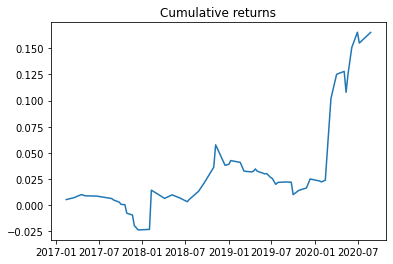

In [21]:
compound_return = np.cumsum(daily_strategy_return)

plt.title('Cumulative returns')
plt.plot(combine['Date'], compound_return)
plt.show()

In [22]:
def calc_max_drawdown(arr):
    maxR, maxD = 0, 0
    cR, cD = 0, 0
    for ele in arr:
        cR += ele
        if cR > maxR:
            maxR = cR
            cD = 0
        else:
            cD += ele
            if cD < maxD:
                maxD = cD
    return maxD - maxR

In [23]:
annualized_return = np.mean(daily_strategy_return) * 250
annualized_stdev = np.std(daily_strategy_return) * np.sqrt(250)
sharpe_ratio = annualized_return / annualized_stdev
max_drawdown = calc_max_drawdown(daily_strategy_return)


In [24]:
print("Sharpe ratio = ", sharpe_ratio)
print("Average annualized return = ", annualized_return)
print("Maximum Drawdown = ", max_drawdown)

Sharpe ratio =  3.226369236364533
Average annualized return =  0.7114215095781243
Maximum Drawdown =  -0.2128268195198797
